Mid term Report title


In [20]:
# Import libraries and modules
import yfinance as yf
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import json
import os


import matplotlib.pyplot as plt
from matplotlib import style

# Show all matplotlib graphs inline
%matplotlib inline  
# using the style for the plot
plt.style.use('dark_background')
# set plot size
plt.rcParams['figure.figsize'] = [30, 15]


In [21]:
#Scope Limits
StartTime = "2012-05-01"
EndTime = "2022-05-01"
TweetLimit = 100


# caching folders
TweetCacheFolder = "CachedTweets"
StockCacheFolder = "CachedStockData"

Collect Twitter Data

In [22]:
#what users do we care about

# names from
# https://en.wikipedia.org/wiki/List_of_most-followed_Twitter_accounts

with open("TwitterUserNames.json", "r") as file:
	usernames = json.load(file)

In [23]:
#get tweets from users
def GetTweetsFromUser(username):

	if not os.path.isdir(TweetCacheFolder):
		os.mkdir(TweetCacheFolder)

	cachePath = os.path.join(TweetCacheFolder, "tweets_" + username + ".csv")

	# cache exists
	if os.path.exists(cachePath):
		df = pd.read_csv(cachePath)

	else:
		query = "(from:" + username + ") since:" + StartTime + " until:" + EndTime
		
		tweets = []
		for tweet in sntwitter.TwitterSearchScraper(query).get_items():

			if len(tweets) == TweetLimit:
				break
			else:
				# print(tweet.json())
				#break
				tweets.append([tweet.date, tweet.user.username, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount, tweet.id])
		
		df = pd.DataFrame(tweets, columns=['Date', 'User', 'Content', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'TweetID'])

		# to save to csv as a cache
		df.to_csv(cachePath)
	

	return df

tweetsDf = GetTweetsFromUser(usernames[0])

In [24]:
for username in usernames:
	tweetsDf = GetTweetsFromUser(username)


Collect Stock Market Data

In [25]:
#load stocks to track
with open("StockTags_SnP.json", "r") as file:
	stockTags = json.load(file)


In [26]:
def LoadStockData(stockTag):

	if not os.path.isdir(StockCacheFolder):
		os.mkdir(StockCacheFolder)

	cachePath = os.path.join(StockCacheFolder, "Stock_" + stockTag + ".csv")

	# cache exists
	if os.path.exists(cachePath):
		df = pd.read_csv(cachePath)

	if not os.path.exists(cachePath):
		stockDataDf = yf.download(stockTag, start=StartTime, end=EndTime, progress=False)

		#save data to local cache file
		stockDataDf.to_csv(cachePath)
	else:

		stockDataDf = pd.read_csv(cachePath)

	return stockDataDf

In [27]:

for stockTag in stockTags:
	LoadStockData(stockTag)



1 Failed download:
- ALXN: No data found, symbol may be delisted

1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted

1 Failed download:
- COG: No data found, symbol may be delisted

1 Failed download:
- FLIR: No data found, symbol may be delisted

1 Failed download:
- HFC: No data found, symbol may be delisted

1 Failed download:
- INFO: No data found, symbol may be delisted

1 Failed download:
- KSU: No data found, symbol may be delisted

1 Failed download:
- LB: No data found, symbol may be delisted

1 Failed download:
- MXIM: No data found, symbol may be delisted

1 Failed download:
- NKE1964: No data found, symbol may be delisted

1 Failed download:
- PBCT: No data found, symbol may be delisted

1 Failed download:
- TPR2017: No data found, symbol may be delisted

1 Failed download:
- VAR: No data found, symbol may be delisted

1 Failed download:
- VIAC: No data found, symbol may b

Now time to review the data downloaded

In [28]:
stockData = LoadStockData(stockTags[0])

In [29]:
def CreateMovingAverage(df, columnToAverage, averageLength):

	movingAverage = []
	movingAverageUpperQuantile = []
	movingAverageLowerQuantile = []

	rows = df.loc[:,columnToAverage]
	for i in range(len(rows)):

		# get window
		if i < averageLength:
			window = [0]
		else:
			window = rows[i - averageLength : i]

		# calculate moving avg
		windowAverage = round(sum(window) / averageLength, 2)
		movingAverage.append(windowAverage)

		# calculate UpperQuantile
		upperQuantile = np.quantile(window, 0.9)
		movingAverageUpperQuantile.append(upperQuantile)

		# calculate LowerQuantile
		lowerQuantile = np.quantile(window, 0.1)
		movingAverageLowerQuantile.append(lowerQuantile)

	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength), movingAverage)
	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength) + "_UpperQuantile", movingAverageUpperQuantile)
	df.insert(len(df.columns), columnToAverage + "MA_" + str(averageLength) + "_LowerQuantile", movingAverageLowerQuantile)
	return

In [30]:
# plt.plot(stockData["Date"], stockData["Volume"], label = "Volume")
plt.plot(stockData["Date"], stockData["VolumeMA_3"], label = "Volume Moving Avg 3")
# plt.plot(stockData["Date"], stockData["VolumeMA_7"], label = "Volume Moving Avg 7")
# plt.plot(stockData["Date"], stockData["VolumeMA_30"], label = "Volume Moving Avg 30")
# plt.plot(stockData["Date"], stockData["VolumeMA_7MA_30"], label = "VolumeMA_7MA_30")
plt.plot(stockData["Date"], stockData["VolumeMA_7MA_30_UpperQuantile"], 'r--', label = "VolumeMA_7MA_30_UpperQuantile")
plt.plot(stockData["Date"], stockData["VolumeMA_7MA_30_LowerQuantile"], 'g--', label = "VolumeMA_7MA_30_LowerQuantile")

# plt.plot(stockData["Date"], stockData["VolumeMA_30_UpperQuantile"], 'r--', label = "VolumeMA_30_UpperQuantile")
# plt.plot(stockData["Date"], stockData["VolumeMA_30_LowerQuantile"], 'g--', label = "VolumeMA_30_LowerQuantile")
plt.legend()
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Avg Volume Over Time")
plt.xticks(stockData["Date"][::int(len(stockData) / 15)])
plt.show()

KeyError: 'VolumeMA_3'

In [37]:
def DetectValueJumping(df, column):
	
	triggerRatio = 0.5
	isValueJumping = []

	for i in range(len(df)):

		# get window
		if i < 45: #skip the first few days as the moving averages take a few days to settle
			isJump = False
		else:
			upperQuantile = df[column + "MA_7MA_30_UpperQuantile"][i]
			lowerQuantile = df[column + "MA_7MA_30_UpperQuantile"][i]
			currentValue = df[column][i]

			interQuantileRange = upperQuantile - lowerQuantile
			triggerRange = triggerRatio * interQuantileRange

			isJump = currentValue > upperQuantile + triggerRange or currentValue < upperQuantile - triggerRange

		isValueJumping.append(isJump)

	df.insert(len(df.columns), column + "_IsJumping", isValueJumping)

	return

def CreateStockTrendData(stockData):

	CreateMovingAverage(stockData, "Volume", 3)
	CreateMovingAverage(stockData, "Volume", 7)
	CreateMovingAverage(stockData, "Volume", 30)
	CreateMovingAverage(stockData, "VolumeMA_7", 30)

	DetectValueJumping(stockData, "Volume")

	CreateMovingAverage(stockData, "Open", 3)
	CreateMovingAverage(stockData, "Open", 7)
	CreateMovingAverage(stockData, "Open", 30)
	CreateMovingAverage(stockData, "OpenMA_7", 30)

	DetectValueJumping(stockData, "Open")

	return



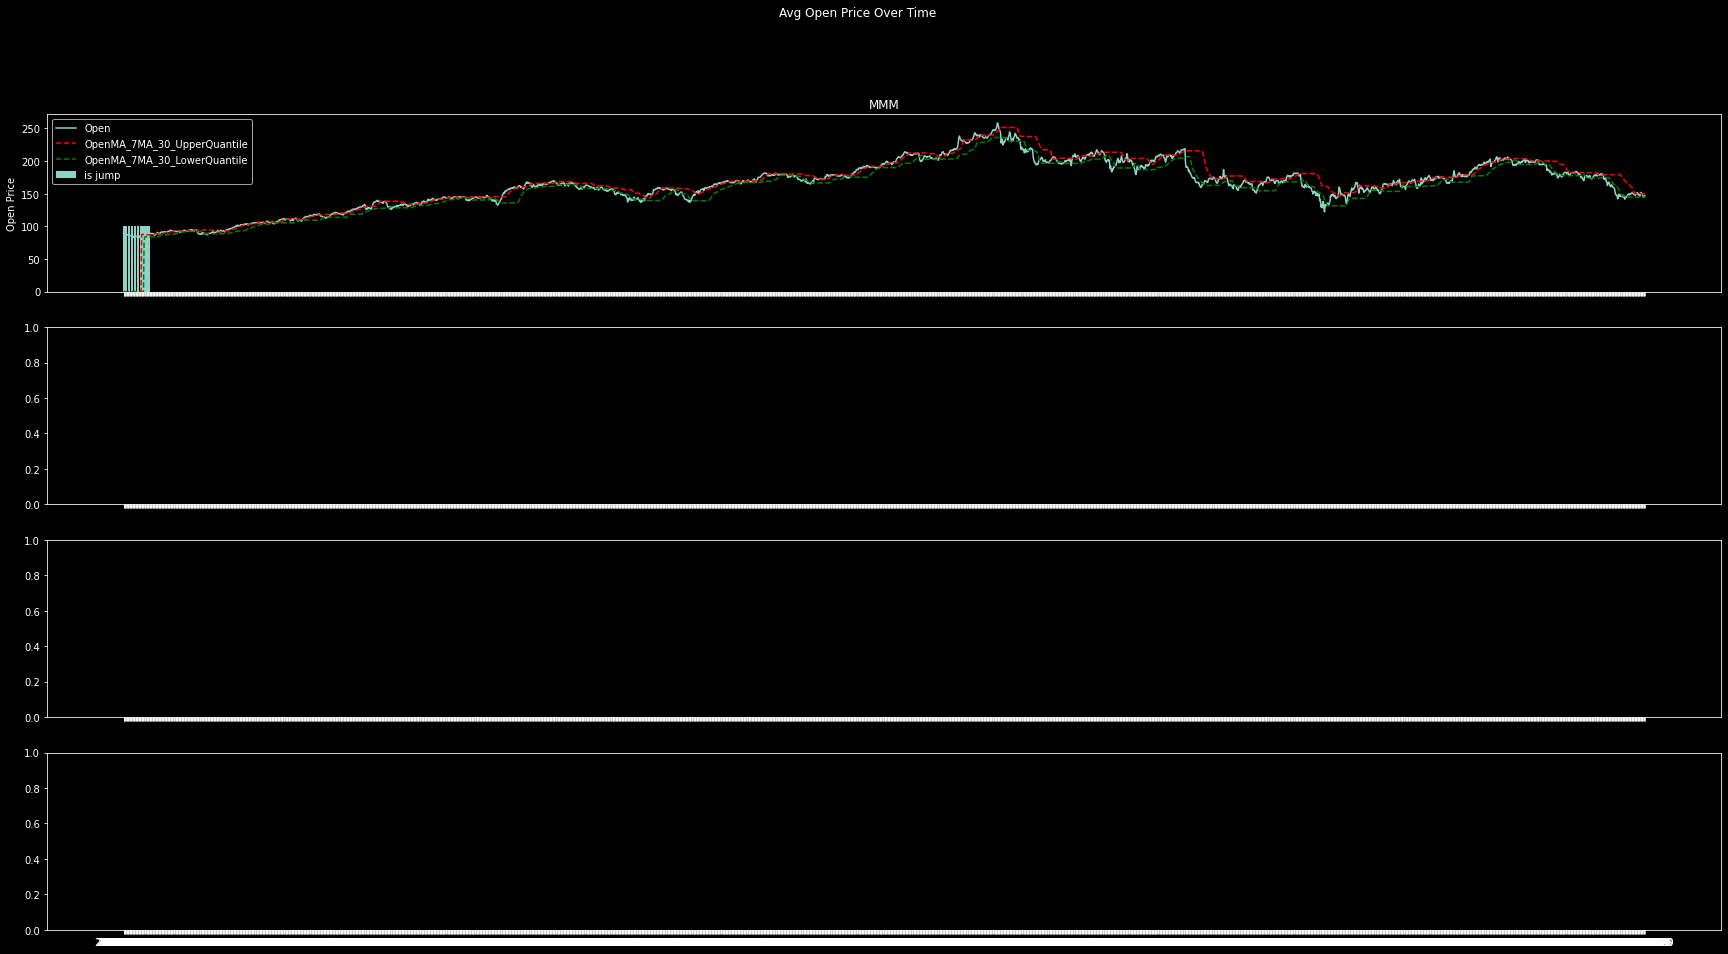

In [48]:
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle("Avg Open Price Over Time")

for i in range(1):
	stockData = LoadStockData(stockTags[i])
	CreateStockTrendData(stockData)

	axs[i].set_title(stockTags[i])
	axs[i].plot(stockData["Date"], stockData["Open"], label = "Open")
	axs[i].plot(stockData["Date"], stockData["OpenMA_7MA_30_UpperQuantile"], 'r--', label = "OpenMA_7MA_30_UpperQuantile")
	axs[i].plot(stockData["Date"], stockData["OpenMA_7MA_30_LowerQuantile"], 'g--', label = "OpenMA_7MA_30_LowerQuantile")
	axs[i].legend()
	# axs[i].xticks(stockData["Date"][::int(len(stockData) / 15)])
	axs[i].set(xlabel='Date', ylabel='Open Price')
	axs[i].label_outer()

axs[1].bar(stockData["Date"], list(np.where(stockData["Open_IsJumping"], 0, 100)), label="is jump")
plt.show()